# 본격적인 전처리 및 데이터 cleanse

In [56]:
# # load 하기. 
# content_orig_total 파일은 data_collect 디렉토리의 get_dart.ipynb에서 생성해야 함.
import pickle
with open("../../../content_orig_total.pickle", "rb") as fp:   # Unpickling the original xml file
  content_orig_total = pickle.load(fp)
len(content_orig_total)



2599

In [57]:
list(content_orig_total[0].keys())

['주식 코드', 'report_idx', '기업 코드', '기업 이름', '수정 일자', 'original_xml', 'contents']

In [58]:
from bs4 import BeautifulSoup
from pathos.pools import ProcessPool
import tqdm.notebook as tq


In [86]:
# 완성품 아래 코드를 복사해서 실제 코드에 옮긴다.
from dart_prcs import *

def preprocess(text):
    try:
        text = re.sub("&cr;", " ", text)
        text = re.sub("\n", "", text) 
        text = re.sub("\"", "", text)
        text = re.sub("\'", "", text)
        text = re.sub("-", "", text)
        text = re.sub("\"", "", text)
        text = re.sub("\'", "", text)
        text = re.sub(",", "", text)
        text = re.sub("(주)", "", text)
        text = re.sub("[(]", " (", text)
        text = re.sub("[)]", ") ", text)
        text = remove_repeated_spacing(text)
        text = clean_punc(text)
        text = remove_useless_breacket(text)
        text = remove_email(text)
        text = remove_url(text)
        text = re.sub('[■\.:%/~㈜&※·→①②$③○-ㆍ」「■>Ⅱ④;▶●?⑤社⑥⑦□=ㅇ『』外<◆△【】現▲▷美∼用☞@前㎡◇中Ⅲ－無新內％◈}株ㅁ會㎥{ㄱⅠ化高＋ㄴ日有：ㄷ公司全後限，〔〕學↑式月|＆ℓㄹ…業人名《》年^韓部▼本大小海│愛故食形㎏獨山多水東可非思州國家生上℃ㅂ合金發在同⊙軍英物實田開○○○○○作性體度産空分子光重ㅅ島間時利＂面母≪㎖資心別氣仁未京來對成雲淸聖命保的集史靑場法神正第一硏㎞ㅡ★太民如理出入下解得安平＝帝所市石門相方元政先富北木自車南地―｜求ㅎㅎ≫西長銀者規制女江福和ㅌ通主義村當代力㎝善原選色；古河──都能動歌〈〉不定ㅠ吉事理張數朝金㎜記書]'\
                      , " ", text)
    except:
        text = ""
    return text

def remove_table(soup):
    for t in soup.find_all('table'):
        t.decompose()
    assert len(soup.find_all('table')) == 0, "table still exists!"

def table_to_text(ss):
    # th: column name인데 간혹 "정 의" 이렇게 띄움. 이런 애들 띄어쓰기 제거
    for rm_t in ss.find_all('th'):
        try:
            rm_t.string.replace_with(re.sub(" ", "", rm_t.text))
        except AttributeError:
            # th안에 <p>제 20 기 3분기말</p>으로 들어가 있는데 얘들은 띄어쓰기 남겨둬야 해서 예외처리
            # try scope에서는 th안의 string 값 자체는 없어서 None으로 처리 됨.
            rm_t.string = rm_t.text
            pass
        except Exception as e:
            print(f"error: {e} in th tag\nerror in th: {rm_t}")
            # print(e)
            # print(rm_t)
            pass

    # 표 같은 경우 text 사이에 개행 / 띄어쓰기가 없음. 정규식 사용해서 전처리하면 다 붙어서 나옴.사 사이사이에 띄어쓰기 넣어줌.
    # exception: 간혹 태그 안에 태그 들어가 있고, 그 아래에 string 들어있음. 바깥으로 꺼내줘서 일관적으로 전처릭 먹도록. 여기에서 앞뒤로 띄어쓰기 넣어넣어줌
    # <td> 안에 <p>가 들어가 있음.

    tag_list = [ "tu", "td", "te", "th" ]
    for tl in tag_list:            
        for rm_t in ss.find_all(tl):
            try:
                rm_t.string.replace_with(" " + rm_t.string + " ")
            except AttributeError:
                # 없는 애들
                rm_t.string = " " + rm_t.text + " "
            except Exception as e: # there are tags with empty string value
                print(f"error: {e}in tu, td, te, th tag\nerror in th: {rm_t}")
                pass
    
    
def parse_content_from_xml(soup, rm_table : bool = True, feature = None):
    contents = {}
    feature_list = [None, "table_to_text", "passage", "passage_list"]
    assert feature in feature_list, f"feature must be either {str(feature_list)}"
    if rm_table:
        remove_table(soup)
        assert len(soup.find_all('table')) == 0, "table still exists!"

    for s in soup.find_all("section-1"):
        title = str(s.title.string)
        sub_chapters = {}
        for ss in s.find_all("section-2"):
            clean_text = None
            sub_title = str(ss.title.string)
            if feature == "table_to_text":
                table_to_text(ss)
                clean_text = str(ss.get_text())
                
            elif feature == "passage":
                psgs_tag = ss.find_all("p")
                psgs = ""
                for p in psgs_tag:
                    psgs += ( " " +p.get_text() )
                clean_text = psgs
                
            elif feature == "passage_list":
                psgs_tag = ss.find_all("p")
                psgs = []
                for p in psgs_tag:
                    pp = p.get_text()
                    if pp: # p tag안에 내용 있을 때
                        psgs.append( pp )
                # clean_text = " ".join(psgs)
                clean_text = psgs
            else:
                clean_text = str(ss.get_text())

            sub_chapters[sub_title] = clean_text
        contents[title] = sub_chapters
    return contents

def parallel_parse_report(cont,rm_table : bool = True, feature = None):
    # print("cleanse_content start")
    def _cleanse(c):
        try:
            soup = BeautifulSoup(c['original_xml'], "lxml")
            c['clean'] = parse_content_from_xml(soup, feature = feature)
        except Exception as e:
            print(e)
            print("cleanse_content error")
            print(cont['기업 이름'])
            c['clean'] = None

    if isinstance(cont, list):
        for c in cont:
            _cleanse(c)
    else:
        # print(cont)
        _cleanse(cont)
    return cont



# 잘돌아가는지 테스트

In [60]:
tmp = content_orig_total[:10] # 10개만 해봅니다. 병렬화 없이!

for t in tq.tqdm( tmp ):
    res = parallel_parse_report(t, feature = "passage_list")
type(res)
res.keys()

# 뜯어보기
# for k , v in res['clean'].items():
#     print("Big ch: ", k)
#     for kk, vv in v.items():
#         print("small ch: ", kk)
#         # print(type(vv))
#         # print(vv)
#         for vvv in vv:
#             print(vvv)
#             print()
#         print()
    

  0%|          | 0/10 [00:00<?, ?it/s]

dict_keys(['주식 코드', 'report_idx', '기업 코드', '기업 이름', '수정 일자', 'original_xml', 'contents', 'clean'])

# passage 잘라서 넣기

In [61]:
# cleanse을 passage list으로 실행
import pandas as pd
from functools import partial
tmp = content_orig_total

clean_conts = []
LIMIT = len(tmp) // 10
for i in tq.tqdm(range(0, len(tmp), LIMIT)): # to expect time per LIMIT
    try:
        pool = ProcessPool()
        res = pool.map( partial(parallel_parse_report, feature = "passage_list"), tmp[i:i+LIMIT] )
        clean_conts.extend( res )
    except Exception as e:
        print("error in cleanse contents: ",e)

  0%|          | 0/11 [00:00<?, ?it/s]

# 석진님 코드의 아이디어를 따와서 자동화

에서 토의했던 대로 없는 값들이 있음. 그런데 그냥 없는 값들은 None으로 넣으면 안되나...?
어차피 STS만 맞으면 되는데...

In [62]:
df = pd.DataFrame(clean_conts)
df_context_mod = df['clean'].map(str)

In [63]:
df_I1, df_I2, df_II1, df_II2, df_II6 = [], [], [], [], []


path = {
        'I. 회사의 개요':['1. 회사의 개요', '2. 회사의 연혁'],\
        'II. 사업의 내용':['1. 사업의 개요', '2. 주요 제품 및 서비스', '6. 주요계약 및 연구개발활동']
       }

df_num = 0
for k, sm_ch_list in path.items():
    df_num += len( sm_ch_list )

df_wrapper = [ df_I1,  df_I2, df_II1, df_II2, df_II6 ] # 넣어야 하는 small ch을 순서대로 배열해야 함

for i in tq.tqdm( range(len(df_context_mod)) ):
    df_idx = 0
    for big_ch , small_ch_list in path.items():
        try:# when big chapter exists
            for small_ch in small_ch_list:
                try: # when small chapter exists
                    psg_list = eval(df_context_mod[i])[big_ch][small_ch]
                    if isinstance(psg_list, list):
                        if len(psg_list) > 0:
                            df_wrapper[df_idx].append( psg_list )
                        else:
                            df_wrapper[df_idx].append( None )
                    elif content == None:
                        df_wrapper[df_idx].append( None )
                    else:
                        raise Exception("the psg list is neither list nor None...")
                except: # when small ch does no exist
                    df_wrapper[df_idx].append( None )
                df_idx += 1
        except: # when big ch does not exist, must input all None
            for df_i in df_num:
                df_wrapper[id_i].append( None )
    
    # try:
    #     df_I1.append(eval(df_context_mod[i])['I. 회사의 개요']['1. 회사의 개요'])
    # except:
    #     df_I1.append(None)
    # try:
    #     df_I2.append(eval(df_context_mod[i])['I. 회사의 개요']['2. 회사의 연혁'])
    # except:
    #     df_I2.append(None)
    # try:
    #     df_II1.append(eval(df_context_mod[i])['II. 사업의 내용']['1. 사업의 개요'])
    # except:
    #     df_II1.append(None)
    # try:
    #     df_II2.append(eval(df_context_mod[i])['II. 사업의 내용']['2. 주요 제품 및 서비스'])
    # except:
    #     df_II2.append(None)
    # try:
    #     df_II6.append(eval(df_context_mod[i])['II. 사업의 내용']['6. 주요계약 및 연구개발활동'])
    # except:
    #     df_II6.append(None)

contexts = {'회사의 개요' : df_I1, '회사의 연혁' : df_I2, '사업의 개요' : df_II1,'주요 제품 및 서비스' : df_II2, '주요계약 및 연구개발활동' : df_II6}

df_plus = pd.DataFrame(contexts)
df_plus
result = pd.concat([df, df_plus], axis=1)
del result['clean']
del result['contents']
del result['original_xml']
# del result['Unnamed: 0']
# del result['Unnamed: 0.1']
print( len(result) )
result.head()
# df.to_csv("dart_v1_2.csv")

  0%|          | 0/2599 [00:00<?, ?it/s]

2599


,주식 코드,report_idx,기업 코드,기업 이름,수정 일자,회사의 개요,회사의 연혁,사업의 개요,주요 제품 및 서비스,주요계약 및 연구개발활동
0,950130,20211115000151,00956028,엑세스바이오,20170630,"[\n1. 연결대상 종속회사 개황(연결재무제표를 작성하는 주권상장법인이 사업보고서,...","[\n가. 엑세스바이오\n, \n나. 종속회사 연혁&cr;- 웰스바이오(주)\n]","[당사는 체외진단 기술을 토대로 면역화학진단, 바이오센서, 분자진단 기술을 기반으...","[\n가. 주요제품 및 제품별 매출액\n, \n※ 연결 기준임&cr;당사의 주요 제...","[\n가. 라이센스 인 계약&cr;1) 올인원 진단제품\n, \n* 본 계약은 20..."
1,033030,20211115002044,00232317,지오엠씨,20170630,[&cr;\n가. 연결대상 종속회사 개황&cr;(1) 연결대상 종속회사 현황(요약)...,"[【(주)지오엠씨 주요 연혁】, ※ 기업공시서식 작성지침에 따라 최근 5 사업연도만...","[가. 영업의 현황, , 당사는 30년간 지속적으로 진행해 오고 있는 엠씨스퀘어 ...","[\n가. 주요 제품 등의 현황\n, \n\n, \n&cr;\n\n나. 주요 제품 ...","[\n가. 연구개발활동의 개요\n, (1) 연구개발 담당조직&cr;\n\n, \n▶..."
2,067130,20211112000043,00419989,클루넷,20170630,"[1. 연결대상 종속회사 개황(연결재무제표를 작성하는 주권상장법인이 사업보고서, 분...","[경영진의 중요한 변동, 공시대상기간('08.01.01.~'17.03.31.) 중 ...",None,None,None
3,139200,20211115002442,00855145,하이골드오션2호선박투자회사,20171127,"[1. 연결대상 종속회사 개황(연결재무제표를 작성하는 주권상장법인이 사업보고서, 분...","[가. 당해 회사의 연혁, (1) 설립 이후의 변동상황, 당사는 2010년 12월 ...","[당사는 선박투자회사법에 따라 케이에스에프선박금융㈜가 발기인이 되어 설립되었으며, ...",None,None
4,900070,20211125000049,00783246,글로벌에스엠,20170703,"[\n1. 연결대상 종속회사 개황(연결재무제표를 작성하는 주권상장법인이 사업보고서,...","[-. 글로벌에스엠테크리미티드, \n\n\n&cr;-. 서울금속(동관)유한공사 \n...","[지주회사(持株會社, Holding Company)란 다른 회사의 주식을 소유한 회...","[가. 주요 제품 등의 현황, (1) 주요 제품 상세 설명, &cr;1) 스크류 &...","[가. 경영상의 주요계약, , 삼성, SONY, 델파이 등 해당 업체의 인증을 거..."


## 각 column 마다 list 마다 전처리

In [64]:
from copy import deepcopy
prcs_result = deepcopy(result)

cols = ['회사의 개요', '회사의 연혁', '사업의 개요', '주요 제품 및 서비스', '주요계약 및 연구개발활동']
for c in tq.tqdm( cols ):
    
    one_col = prcs_result[c] # get the target column
    num_psgs = []
    for i, one_corp in enumerate( one_col ): # for each corp in one column
        if one_corp == None:
            continue
        prcs_psgs = []
        for psg in one_corp: # for each string in one corp
            prcs_psg = preprocess(psg)
            if prcs_psg: # remove empty string
                prcs_psgs.append( prcs_psg )
        one_col[i] = prcs_psgs
        # num_psg = len(one_corp)
        # num_psgs.append( num_psg )
print(len(prcs_result))
prcs_result.head()

  0%|          | 0/5 [00:00<?, ?it/s]

2599


,주식 코드,report_idx,기업 코드,기업 이름,수정 일자,회사의 개요,회사의 연혁,사업의 개요,주요 제품 및 서비스,주요계약 및 연구개발활동
0,950130,20211115000151,00956028,엑세스바이오,20170630,[1 연결대상 종속회사 개황 (연결재무제표를 작성하는 권상장법인이 사업보고서 분기...,"[가 엑세스바이오, 나 종속회사 연혁 웰스바이오]",[당사는 체외진단 기술을 토대로 면역화학진단 바이오센서 분자진단 기술을 기반으로 진...,"[가 요제품 및 제품별 매출액, 연결 기준임 당사의 요 제품은 말라리아 진단시...","[가 라이센스 인 계약 1) 올인원 진단제품, * 본 계약은 2021년 10월 3..."
1,033030,20211115002044,00232317,지오엠씨,20170630,"[가 연결대상 종속회사 개황 (1) 연결대상 종속회사 현황 (요약), (11) 연...","[ 지오엠씨 요 연혁 , 기업공시서식 작성지침에 따라 최근 5 사업연도만 기...","[가 영업의 현황, 당사는 30년간 지속적으로 진행해 오고 있는 엠씨스퀘어 사업 ...","[가 요 제품 등의 현황, 나 요 제품 등의 가격변동추이 (단위 원)]","[가 연구개발활동의 개요, (1) 연구개발 담당조직, 기술연구소 (인원 1명)..."
2,067130,20211112000043,00419989,클루넷,20170630,[1 연결대상 종속회사 개황 (연결재무제표를 작성하는 권상장법인이 사업보고서 분기...,"[경영진의 중요한 변동, 공시대상기간 (08 01 01 17 03 31 ) 중 회...",None,None,None
3,139200,20211115002442,00855145,하이골드오션2호선박투자회사,20171127,[1 연결대상 종속회사 개황 (연결재무제표를 작성하는 권상장법인이 사업보고서 분기...,"[가 당해 회사의 연혁, (1) 설립 이후의 변동상황, 당사는 2010년 12월 ...",[당사는 선박투자회사법에 따라 케이에스에프선박금융 가 발기인이 되어 설립되었으며 선...,None,None
4,900070,20211125000049,00783246,글로벌에스엠,20170703,[1 연결대상 종속회사 개황 (연결재무제표를 작성하는 권상장법인이 사업보고서 분기...,"[ 글로벌에스엠테크리미티드, 서울금속 (동관) 유한공사 (이하 동관법인), ...",[지회사 (持 Holding Company) 란 다른 회사의 식을 소유한 회사...,"[가 요 제품 등의 현황, (1) 요 제품 상세 설명, 1) 스크류 스크류는 모든...","[가 경영상의 요계약, 삼성 SONY 델파이 등 해당 업체의 인증을 거쳐 판매를 ..."


# passage 데이터의 크기
1. 그래서 1개의 기업 당 몇개의 passage들이 있을까? => 1개의 기업 당 만들 수 있는 데이터의 수. 


(array([ 24.,  32.,  41.,  44.,  81., 182., 193., 274., 216., 202., 234.,
        131., 125.,  96.,  65.,  71.,  56.,  69.,  31.,  31.,  51.,  20.,
         29.,  21.,  16.,  22.,  18.,  17.,  19.,  17.,  20.,   9.,  14.,
         14.,   8.,   9.,  11.,   7.,   7.,   6.,   6.,   5.,   2.,   2.,
          1.,   3.,   1.,   1.,   2.,   3.,   5.,   2.,   0.,   4.,   2.,
          0.,   0.,   2.,   4.,   2.,   2.,   0.,   0.,   1.,   0.,   1.,
          4.,   2.,   1.,   1.,   0.,   1.,   0.,   1.,   0.,   1.,   0.,
          1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([  0. ,   3.4,   6.8,  10.2,  13.6,  17. ,  20.4,  23.8,  27.2,
         30.6,  34. ,  37.4,  40.8,  44.2,  47.6,  51. ,  54.4,  57.8,
         61.2,  64.6,  68. ,  71.4,  74.8,  78.2,  81.6,  85. ,  88.4,
         91.8,  95.2,  98.6, 102. , 105.4, 108.8, 112.2, 115.6, 119. ,
        122.4, 125.8, 129.2, 132.6

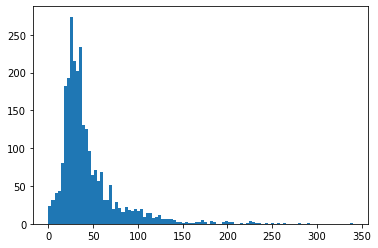

In [65]:
cols = ['회사의 개요', '회사의 연혁', '사업의 개요', '주요 제품 및 서비스', '주요계약 및 연구개발활동']

num_data_per_corp = []

for row_idx in range( len(prcs_result) ):
    corp = prcs_result.iloc[row_idx]
    
    num_psg_per_corp = 0
    for col in cols:
        psg_list = corp[col]
        
        if psg_list == None:
            continue
        num_psg_per_sm_ch = len( psg_list )
        num_psg_per_corp += num_psg_per_sm_ch
    num_data_per_corp.append( num_psg_per_corp )

import matplotlib.pyplot as plt
fig,ax = plt.subplots(1)
ax.hist(num_data_per_corp, bins = 100)

비율 확인 해보자. 대부분의 corp가 30개?

In [66]:
import numpy as np
num_data = np.array(num_data_per_corp)
np.quantile(num_data, 0.5)
low, mid_low, mid_high = np.quantile(num_data,[0.25, 0.5, 0.75])
low, mid_low, mid_high

(24.0, 34.0, 51.0)

In [67]:
# 최대 최소
pd.DataFrame(num_data).describe()

,0
count,2599.000000
mean,44.011543
std,34.621275
min,0.000000
25%,24.000000
50%,34.000000
75%,51.000000
max,340.000000


In [68]:
# 살펴보기
cols = ['회사의 개요', '회사의 연혁', '사업의 개요', '주요 제품 및 서비스', '주요계약 및 연구개발활동']

low_data = []
mid_low_data = []
mid_high_data = []
high_data = []


for row_idx in range( len(prcs_result) ):
    corp = prcs_result.iloc[row_idx]
    
    num_psg_per_corp = 0
    for col in cols:
        psg_list = corp[col]
        
        if psg_list == None:
            continue
        num_psg_per_sm_ch = len( psg_list )
        num_psg_per_corp += num_psg_per_sm_ch
    # check quantile correct    
    if num_psg_per_corp < low:
        low_data.append( row_idx )
    elif low <= num_psg_per_corp < mid_low:
        mid_low_data.append( row_idx )
    elif mid_low <= num_psg_per_corp < mid_high:
        mid_high_data.append( row_idx )
    elif mid_high <= num_psg_per_corp:
        high_data.append( row_idx )
len (low_data), len (mid_low_data) , len (mid_high_data), len (high_data)


(597, 692, 651, 659)

In [69]:
# low num of data check
tmp_list = []
for idx in low_data:
    tmp_list.append( prcs_result.iloc[idx] )
pd.DataFrame( tmp_list ).head()

,주식 코드,report_idx,기업 코드,기업 이름,수정 일자,회사의 개요,회사의 연혁,사업의 개요,주요 제품 및 서비스,주요계약 및 연구개발활동
2,067130,20211112000043,00419989,클루넷,20170630,[1 연결대상 종속회사 개황 (연결재무제표를 작성하는 권상장법인이 사업보고서 분기...,"[경영진의 중요한 변동, 공시대상기간 (08 01 01 17 03 31 ) 중 회...",None,None,None
3,139200,20211115002442,00855145,하이골드오션2호선박투자회사,20171127,[1 연결대상 종속회사 개황 (연결재무제표를 작성하는 권상장법인이 사업보고서 분기...,"[가 당해 회사의 연혁, (1) 설립 이후의 변동상황, 당사는 2010년 12월 ...",[당사는 선박투자회사법에 따라 케이에스에프선박금융 가 발기인이 되어 설립되었으며 선...,None,None
12,007150,20210331000941,00117638,동양텔레콤,20200226,[가 회사의 법적 상업적 명칭은 동양텔레콤 식회사라고 표기합니다 또한 영문으로는...,[공시대상기간 (최근5사업연도) 중 회사의 된 변동사항은 다음과 같습니다 ],None,None,None
13,043580,20211115001240,00222806,에임하이글로벌,20200228,[1 연결대상 종속회사 개황 (연결재무제표를 작성하는 권상장법인이 사업보고서 분기...,"[1 본점 소재지의 변동, 2 경영진의 중요한 변동 (대표이사를 포함한 1 3이...",[가 사업부문별 현황 당사의 사업부문은 모바일 및 온라인 게임 캐릭터라이센싱 사업...,[요 제품 등의 현황 (별도재무제표 기준) (2021년 09월 30일 현재) (단위...,[해당사항 없음]
15,065310,20211115000486,00307037,더스텔라,20200408,[1 연결대상 종속회사 개황 (연결재무제표를 작성하는 권상장법인이 사업보고서 분기...,[가 설립이후의 변동상황 1990 06 정호코리아 설립 1992 03 베트남 하...,[당사는 가방사업부문과 의류사업부문을 함께 운영해 오다가 2009 07 의류사업부문...,"[가 요 제품의 내용, 나 요 제품 등의 가격변동추이 (단위 US ), (1...","[1) 연구개발 담당조직, 패션트랜드 변화의 가속화로 의류업계에 지속적인 시장점유가..."


In [70]:
# mid_low num of data check
tmp_list = []
for idx in mid_low_data:
    tmp_list.append( prcs_result.iloc[idx] )
pd.DataFrame( tmp_list ).head()

,주식 코드,report_idx,기업 코드,기업 이름,수정 일자,회사의 개요,회사의 연혁,사업의 개요,주요 제품 및 서비스,주요계약 및 연구개발활동
7,900340,20210830000685,01328639,윙입푸드,20181130,"[가 연결대상 종속회사 개황 11 연결대상 종속회사 현황 (요약), 12 연결대...","[가 회사가 속해 있는 그룹의 연혁, 나 회사의 본점소재지 및 그 변경, 다 ...",[당사는 한국 표준산업 분류 기준 대분류상 식료품 제조업 산업에 세분류상 가금류 가...,"[가 요 제품 등의 현황, ) 전통식품에 중국식 살라미 중국식 베이컨 기타제품이 ...","[가 요계약 보고서 작성기준일 현재 해당사항 없습니다 , 나 연구개발 조직, (..."
9,900260,20210827000580,01139266,로스웰,20190312,"[가 연결대상 종속회사 개황 (1) 연결대상 종속회사 현황 (요약), (2) 연결...","[가 당해 기업의 연혁, 나 계열회사의 연혁 [양보싱], [강소로스웰], 다 ...",[당사와 연결종속회사의 된 영업활동은 자동차용 전장제품의 연구개발과 제조 및 유통이...,"[가 요 제품 등의 현황, 나 요제품의 가격변동 추이, ) 제품은 패키지 단위로...","[가 연구개발 조직, 나 연구개발비용 (단위 천 RMB), 다 지적재산권 현..."
14,041500,20211115000272,00291152,디비엘,20200508,[1 연결대상 종속회사 개황 (연결재무제표를 작성하는 권상장법인이 사업보고서 분기...,"[가 설립 이후의 변동상황, 나 상호의 변경, 다 합병 분할 (합병) 포괄적 ...","[가 업계의 현황, 1) 산업의 특성, 가) 기술집약적 산업 무병실험동물이 생산되...","[가 요 제품 등의 현황, 나 요 제품 등의 가격변동추이, (단위 원), 1...",[해당사항 없음]
18,950110,20211112000232,00938688,SBI핀테크솔루션즈,20200401,[가 회사의 법적 상업적 명칭 당사의 명칭은 SBI FinTech Solution...,"[가 회사의 연혁, (1) 회사 및 요 종속회사의 연혁 [SBI FinTech S...",[당사 그룹은 종합 핀테크 솔루션 기업으로 결제서비스 사업 개인머니서비스 사업 기업...,"[가 요 서비스 매출, 1) 상기 매출액은 외부고객으로부터의 수익에서 연결대상 법...","[가 경영상의 요 계약 등, 나 연구개발활동, (1) 연구개발 담당조직, 결제서..."
23,139130,20211115001910,00878915,DGB금융지주,20201118,[1 연결대상 종속회사 개황 (연결재무제표를 작성하는 권상장법인이 사업보고서 분기...,[가 본점 소재지 대구광역시 북구 옥산로 111 (칠성동2가) 나 연혁 2011...,[가 DGB금융지 사업의 개요 DGB금융지는 2011년 5월 설립이후 대구은행...,None,None


In [71]:
# low num of data check
tmp_list = []
for idx in mid_high_data:
    tmp_list.append( prcs_result.iloc[idx] )
pd.DataFrame( tmp_list ).head()

,주식 코드,report_idx,기업 코드,기업 이름,수정 일자,회사의 개요,회사의 연혁,사업의 개요,주요 제품 및 서비스,주요계약 및 연구개발활동
0,950130,20211115000151,00956028,엑세스바이오,20170630,[1 연결대상 종속회사 개황 (연결재무제표를 작성하는 권상장법인이 사업보고서 분기...,"[가 엑세스바이오, 나 종속회사 연혁 웰스바이오]",[당사는 체외진단 기술을 토대로 면역화학진단 바이오센서 분자진단 기술을 기반으로 진...,"[가 요제품 및 제품별 매출액, 연결 기준임 당사의 요 제품은 말라리아 진단시...","[가 라이센스 인 계약 1) 올인원 진단제품, * 본 계약은 2021년 10월 3..."
8,046400,20211112000126,00263140,루트원플러스,20190128,[1 연결대상 종속회사 개황 (연결재무제표를 작성하는 권상장법인이 사업보고서 분기...,[가 회사의 법적 상업적 명칭 당사의 명칭은 식회사 휴스토리라고 표기합니다 또...,[사업의 개요 가 업계의 현황 (1) 사업부분의 내용 당사는 제조현장에서 제품생산...,"[가 요 제품 등의 현황, 나 요 제품 등의 가격변동추이 (단위 원), 요 ...","[ 요계약, 해당사항없음, 연구개발활동, 가 연구개발활동의 개요 (1) 연구..."
11,026220,20211115000305,00133317,에스티씨라이프,20190906,"[가 회사의 법적상업적 명칭, 당사의 명칭은 식회사 에스티씨라이프 라고 표기합니다...",[공시대상기간 (2010 01 01 2021 09 30) 중 회사의 된 변...,None,None,None
16,950160,20211115002390,01245062,코오롱티슈진,20200325,"[가 연결대상 종속회사 개황 가1 연결대상 종속회사 현황 (요약), 가2 연결...","[가 회사의 연혁, 나1 경영진의 중요한 변동, 1) 최근 5년간 대표이사 변동...",[당사는 세포 유전자 기술인 TGC Platform을 이용한 신약개발기업으로써 무릎...,"[가 요 제품 등의 현황 [미화 기준], [원화 기준], (1) 요 제품 설명 [...","[경영상의 요계약, 가 라이센스아웃 (Licenseout) 계약 공시서류 작성기준일..."
20,025890,20211115000631,00159564,한국주강,20201130,[1 연결대상 종속회사 개황 (연결재무제표를 작성하는 권상장법인이 사업보고서 분기...,[공시대상기간 (최근5사업년도) 중 계열회사 및 요종속회사의 된 변동내역은 아래와 ...,"[1 사업의 개요 가 업계의 현황, (1) 산업의 특성, (가) 강은 고철을 용...","[가 요 제품 등의 현황, 나 요 제품 등의 가격변동추이, (1) 산출기준, 매...",[가 경영상의 요계약 해당사항 없음 나 연구개발활동 1) 연구개발활동 개요 당사...


In [72]:
# low num of data check
tmp_list = []
for idx in high_data:
    tmp_list.append( prcs_result.iloc[idx] )
pd.DataFrame( tmp_list ).head()

,주식 코드,report_idx,기업 코드,기업 이름,수정 일자,회사의 개요,회사의 연혁,사업의 개요,주요 제품 및 서비스,주요계약 및 연구개발활동
1,033030,20211115002044,00232317,지오엠씨,20170630,"[가 연결대상 종속회사 개황 (1) 연결대상 종속회사 현황 (요약), (11) 연...","[ 지오엠씨 요 연혁 , 기업공시서식 작성지침에 따라 최근 5 사업연도만 기...","[가 영업의 현황, 당사는 30년간 지속적으로 진행해 오고 있는 엠씨스퀘어 사업 ...","[가 요 제품 등의 현황, 나 요 제품 등의 가격변동추이 (단위 원)]","[가 연구개발활동의 개요, (1) 연구개발 담당조직, 기술연구소 (인원 1명)..."
4,900070,20211125000049,00783246,글로벌에스엠,20170703,[1 연결대상 종속회사 개황 (연결재무제표를 작성하는 권상장법인이 사업보고서 분기...,"[ 글로벌에스엠테크리미티드, 서울금속 (동관) 유한공사 (이하 동관법인), ...",[지회사 (持 Holding Company) 란 다른 회사의 식을 소유한 회사...,"[가 요 제품 등의 현황, (1) 요 제품 상세 설명, 1) 스크류 스크류는 모든...","[가 경영상의 요계약, 삼성 SONY 델파이 등 해당 업체의 인증을 거쳐 판매를 ..."
5,900120,20211028000448,00800084,씨케이에이치,20170703,"[(1) 연결대상 종속회사 개황연결대상 종속회사 현황 (요약), (1) 1 연결대...","[(1) 당해 기업의 연혁, (2) 종속회사의 연혁 가 복건금산대도건강과기그룹유한...",[가 산업개황 및 전망 당사의 매출과 이익은 중국 내에서의 건강식품 생산 및 판매...,"[가 요 제품등의 현황, 1) 당사는 수출이 없으며 전액 중국내수판매입니다 나 ...","[가 토지사용권및기지임대, ) 계약금액 취득부대비용을 제외한 계약서 상 금액, ..."
6,900290,20211028000456,01170962,GRT,20181122,"[가 연결대상 종속회사 현황 (요약), 11 연결대상회사의 변동내용, 나 회사...",[가 회사가 속해 있는 그룹의 연혁 당사가 속해 있는 그룹은 당사를 지배회사로 하...,"[가 산업의 이해 (1) 영위하고 있는 사업, 당사의 요 사업영역으로는 정밀 코팅...","[가 요 제품 등의 현황, 나 요제품의 가격변동 추이]",[강음통리광전과기유한회사는 전문 기술부를 설립하여 신제품의 연구개발을 담당하고 있습...
10,900280,20210830001104,01168143,골든센츄리,20190703,"[1 연결대상 종속회사 개황, 11 연결대상회사의 변동내용, 중소기업 등 해당 ...","[가 회사가 속해 있는 그룹의 연혁, 나 회사의 본점소재지 및 그 변경 본점 소...",[가 산업의 이해 1) 영위하고 있는 사업 당사의 실질 영업회사는 중국 내 있는 ...,"[가 요 제품 등의 현황, 나 요 제품 등의 가격변동추이, 다 요 제품 등 관...",[가 연구개발 개요 신규 제품의 디자인 혹은 금형의 개발 등 연구개발 활동은 각 ...


### 2. 각 passage의 길이는 어느 정도?

(array([1.691e+03, 3.120e+02, 1.700e+02, 1.050e+02, 5.700e+01, 4.800e+01,
        4.000e+01, 2.400e+01, 1.800e+01, 2.400e+01, 1.900e+01, 1.100e+01,
        8.000e+00, 8.000e+00, 6.000e+00, 7.000e+00, 5.000e+00, 5.000e+00,
        2.000e+00, 3.000e+00, 3.000e+00, 0.000e+00, 2.000e+00, 1.000e+00,
        4.000e+00, 5.000e+00, 1.000e+00, 3.000e+00, 3.000e+00, 0.000e+00,
        2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

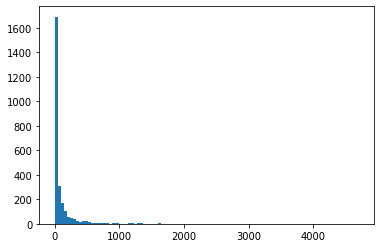

In [73]:
cols = ['회사의 개요', '회사의 연혁', '사업의 개요', '주요 제품 및 서비스', '주요계약 및 연구개발활동']

all_corp_len = []

for row_idx in range( len(prcs_result) ):
    corp = prcs_result.iloc[row_idx]
    
    len_psg_per_corp = []
    for col in cols:
        psg_list = corp[col]
        
        if psg_list == None:
            continue
            
        # for each passage 
        for psg in psg_list:
            len_psg = len(psg)
        num_psg_per_corp += len_psg
    all_corp_len.append( len_psg )

import matplotlib.pyplot as plt
fig,ax = plt.subplots(1)
ax.hist(all_corp_len, bins = 100)

In [74]:
pd.DataFrame(all_corp_len).describe()

,0
count,2599.000000
mean,98.366295
std,233.886961
min,1.000000
25%,10.000000
50%,29.000000
75%,85.000000
max,4707.000000


In [75]:
low, mid_low, mid_high = np.quantile( np.array(all_corp_len), [0.25, 0.5, 0.75])
low, mid_low, mid_high

(10.0, 29.0, 85.0)

In [76]:


low_data = []
mid_low_data = []
mid_high_data = []
high_data = []

cols = ['회사의 개요', '회사의 연혁', '사업의 개요', '주요 제품 및 서비스', '주요계약 및 연구개발활동']


for row_idx in range( len(prcs_result) ):
    corp = prcs_result.iloc[row_idx]
    
    len_psg_per_corp = []
    for col in cols:
        psg_list = corp[col]
        
        if psg_list == None:
            continue
            
        # for each passage 
        for psg in psg_list:
            len_psg = len(psg)
            if len_psg <= low:
                low_data.append(psg)
low_data[:100]

['가  엑세스바이오',
 '3) 연구개발비용',
 '[연결]',
 '[별도]',
 '  분자진단',
 '  Hb 센서 개발',
 '나  상호의 변경',
 '가  영업의 현황',
 '나  연구개발 실적',
 '라  최대의 변경',
 '마  상호의 변경',
 '(2) 상호의 변경',
 '해당사항 없음',
 '해당사항 없음',
 '해당사항 없음',
 '해당사항 없음',
 '해당사항 없음',
 '  누리온',
 '(1) 업계 개황',
 '㉱ 산업연관도',
 '나  회사의 현황',
 '(1) 시장의 특성',
 '1) 요 목표 시장',
 '(가) 동관법인',
 '(나) 천진법인',
 '(다) 혜법인',
 '(라) 위해법인',
 '(마) 베트남법인',
 '(바) 필리핀법인',
 '(아) 스페인법인',
 '(자) 루마니아법인',
 '(가) 동관법인',
 '(다) 혜법인',
 '(라) 위해법인',
 '(자) 루마니아법인',
 '나  연구개발활동',
 '단위   명',
 '1) 글로벌 시장',
 '2) 중국 시장',
 '(6) 제품의 구성',
 '3) 연구개발계획',
 '나  연구개발비용',
 '공시 대리인',
 '라  최대의 변동',
 '(마) 마케팅 우위',
 '(바) 인재 우위',
 '(사) 자금 우위',
 '(아) 고객 우위',
 '다  연구개발 비용',
 '광동영업식품',
 '해남영업식품',
 '라  최대의 변동',
 '마  상호의 변경',
 '나  연구개발 조직',
 '  경기변동의 특성',
 '나  회사의 현황',
 '(1) 영업개황',
 '(3) 시장의 특성',
 '  요계약',
 '해당사항없음',
 '  연구개발활동',
 '나  연구개발 실적',
 '[강소로스웰]',
 '가  연구개발 조직',
 '발명특허',
 '실용신안',
 '  그룹 지배구조',
 '공시대리인',
 '출처  중국통계청',
 '출처  중국통계청',
 '출처  중국통계청',
 '다) 수요 변동요인',
 '출처  중국재무부',
 '마) 산업환경',
 '1) 정책환경',
 '2) 경제환경',
 '

In [77]:
prcs_result.head()

,주식 코드,report_idx,기업 코드,기업 이름,수정 일자,회사의 개요,회사의 연혁,사업의 개요,주요 제품 및 서비스,주요계약 및 연구개발활동
0,950130,20211115000151,00956028,엑세스바이오,20170630,[1 연결대상 종속회사 개황 (연결재무제표를 작성하는 권상장법인이 사업보고서 분기...,"[가 엑세스바이오, 나 종속회사 연혁 웰스바이오]",[당사는 체외진단 기술을 토대로 면역화학진단 바이오센서 분자진단 기술을 기반으로 진...,"[가 요제품 및 제품별 매출액, 연결 기준임 당사의 요 제품은 말라리아 진단시...","[가 라이센스 인 계약 1) 올인원 진단제품, * 본 계약은 2021년 10월 3..."
1,033030,20211115002044,00232317,지오엠씨,20170630,"[가 연결대상 종속회사 개황 (1) 연결대상 종속회사 현황 (요약), (11) 연...","[ 지오엠씨 요 연혁 , 기업공시서식 작성지침에 따라 최근 5 사업연도만 기...","[가 영업의 현황, 당사는 30년간 지속적으로 진행해 오고 있는 엠씨스퀘어 사업 ...","[가 요 제품 등의 현황, 나 요 제품 등의 가격변동추이 (단위 원)]","[가 연구개발활동의 개요, (1) 연구개발 담당조직, 기술연구소 (인원 1명)..."
2,067130,20211112000043,00419989,클루넷,20170630,[1 연결대상 종속회사 개황 (연결재무제표를 작성하는 권상장법인이 사업보고서 분기...,"[경영진의 중요한 변동, 공시대상기간 (08 01 01 17 03 31 ) 중 회...",None,None,None
3,139200,20211115002442,00855145,하이골드오션2호선박투자회사,20171127,[1 연결대상 종속회사 개황 (연결재무제표를 작성하는 권상장법인이 사업보고서 분기...,"[가 당해 회사의 연혁, (1) 설립 이후의 변동상황, 당사는 2010년 12월 ...",[당사는 선박투자회사법에 따라 케이에스에프선박금융 가 발기인이 되어 설립되었으며 선...,None,None
4,900070,20211125000049,00783246,글로벌에스엠,20170703,[1 연결대상 종속회사 개황 (연결재무제표를 작성하는 권상장법인이 사업보고서 분기...,"[ 글로벌에스엠테크리미티드, 서울금속 (동관) 유한공사 (이하 동관법인), ...",[지회사 (持 Holding Company) 란 다른 회사의 식을 소유한 회사...,"[가 요 제품 등의 현황, (1) 요 제품 상세 설명, 1) 스크류 스크류는 모든...","[가 경영상의 요계약, 삼성 SONY 델파이 등 해당 업체의 인증을 거쳐 판매를 ..."


In [78]:
prcs_result.isna()['사업의 개요'].value_counts()

False    2410
True      189
Name: 사업의 개요, dtype: int64

In [79]:
prcs_result.isna()['회사의 개요'].value_counts()

False    2594
True        5
Name: 회사의 개요, dtype: int64

In [87]:
cond1 = prcs_result.isna()['사업의 개요'] == False

tmp = prcs_result[ cond1 ]

cond2 = tmp.isna()['회사의 개요'] == False
prcs_result = tmp[ cond2 ]
prcs_result

,주식 코드,report_idx,기업 코드,기업 이름,수정 일자,회사의 개요,회사의 연혁,사업의 개요,주요 제품 및 서비스,주요계약 및 연구개발활동
0,950130,20211115000151,00956028,엑세스바이오,20170630,[1 연결대상 종속회사 개황 (연결재무제표를 작성하는 권상장법인이 사업보고서 분기...,"[가 엑세스바이오, 나 종속회사 연혁 웰스바이오]",[당사는 체외진단 기술을 토대로 면역화학진단 바이오센서 분자진단 기술을 기반으로 진...,"[가 요제품 및 제품별 매출액, 연결 기준임 당사의 요 제품은 말라리아 진단시...","[가 라이센스 인 계약 1) 올인원 진단제품, * 본 계약은 2021년 10월 3..."
1,033030,20211115002044,00232317,지오엠씨,20170630,"[가 연결대상 종속회사 개황 (1) 연결대상 종속회사 현황 (요약), (11) 연...","[ 지오엠씨 요 연혁 , 기업공시서식 작성지침에 따라 최근 5 사업연도만 기...","[가 영업의 현황, 당사는 30년간 지속적으로 진행해 오고 있는 엠씨스퀘어 사업 ...","[가 요 제품 등의 현황, 나 요 제품 등의 가격변동추이 (단위 원)]","[가 연구개발활동의 개요, (1) 연구개발 담당조직, 기술연구소 (인원 1명)..."
3,139200,20211115002442,00855145,하이골드오션2호선박투자회사,20171127,[1 연결대상 종속회사 개황 (연결재무제표를 작성하는 권상장법인이 사업보고서 분기...,"[가 당해 회사의 연혁, (1) 설립 이후의 변동상황, 당사는 2010년 12월 ...",[당사는 선박투자회사법에 따라 케이에스에프선박금융 가 발기인이 되어 설립되었으며 선...,None,None
4,900070,20211125000049,00783246,글로벌에스엠,20170703,[1 연결대상 종속회사 개황 (연결재무제표를 작성하는 권상장법인이 사업보고서 분기...,"[ 글로벌에스엠테크리미티드, 서울금속 (동관) 유한공사 (이하 동관법인), ...",[지회사 (持 Holding Company) 란 다른 회사의 식을 소유한 회사...,"[가 요 제품 등의 현황, (1) 요 제품 상세 설명, 1) 스크류 스크류는 모든...","[가 경영상의 요계약, 삼성 SONY 델파이 등 해당 업체의 인증을 거쳐 판매를 ..."
5,900120,20211028000448,00800084,씨케이에이치,20170703,"[(1) 연결대상 종속회사 개황연결대상 종속회사 현황 (요약), (1) 1 연결대...","[(1) 당해 기업의 연혁, (2) 종속회사의 연혁 가 복건금산대도건강과기그룹유한...",[가 산업개황 및 전망 당사의 매출과 이익은 중국 내에서의 건강식품 생산 및 판매...,"[가 요 제품등의 현황, 1) 당사는 수출이 없으며 전액 중국내수판매입니다 나 ...","[가 토지사용권및기지임대, ) 계약금액 취득부대비용을 제외한 계약서 상 금액, ..."
...,...,...,...,...,...,...,...,...,...,...
2594,340440,20211115000416,01416572,한화플러스제1호스팩,20211125,"[가 연결대상 종속회사 개황 (1) 연결대상 종속회사 현황 (요약), (2) ...",[가 회사의 본점소재지 및 그 변경 본점소재지 서울특별시 영등포구 여의대로 56...,[당사는 자본시장법 에 따라 회사의 권을 한국거래소 코스닥시장에 상장한 후 다른 ...,[당사는 기업인수목적회사로 해당사항 없습니다 ],[당사는 기업인수목적회사로 해당사항 없습니다 ]
2595,137950,20211111000044,00664853,제이씨케미칼,20211126,[제이씨케미칼 의 보고서 제출 기준일 현재 연결대상 종속회사는 3개사이며 회사의 ...,"[공시대상기간 (최근5사업연도) 중 회사의 된 변동사항은 다음과 같습니다 , 가 ...","[가 바이오연료 (바이오디젤 바이오중유), 당사는 신재생에너지인 바이오연료 중 바...","[가 요제품 현황 (바이오연료) (단위 백만원), 나 요 제품 등의 가격변동 추...","[가 비경상적인 중요계약 해당사항 없음 나 연구개발활동, (1) 연구개발활동의 ..."
2596,009540,20211115001694,00164830,한국조선해양,20211022,"[가 연결대상 종속회사 개황, 요종속회사 판단기준 최근사업연도말 자산 총액 ...",[가 회사의 본점소재지 및 그 변경 본점의 소재지 서울특별시 종로구 율곡로 ...,[가 지회사 현황 지회사 (持 Holding Company) 란 다른 회사의...,"[가 요 제품 등의 현황, 상기 매출액은 요 종속회사를 포함한 연결기준 매출액...","[가 경영상의 요계약 등, 당사 및 요 종속회사의 경영상의 요계약은 다음과 같습니..."
2597,128820,20211115000893,00828789,대성산업,20211111,[가 회사의 법적 상업적 명칭 당사의 명칭은 대성산업 식회사라고 표기합니다 영문...,[가 회사의 본점소재지 및 그 변경 당사의 본점소재지는 서울특별시 구로구 경인로 ...,[당사는 1947년 대성산업공사를 모태로 설립되어 석유가스사업 에너지사업 기계사업 ...,"[당분기말 현재 연결회사의 요 제품 서비스 등의 매출 비중은 다음과 같습니다 , *...","[가 경영상의 요계약 등, 신설법인 대성산업 은 분할전 대성산업 의 상기 ..."


In [88]:
prcs_result.to_csv("dart_v3_01.csv")

## V3.1: 모델에 맞게 1개의 passage 당 1개의 데이터.
중복 시킨다?

In [81]:

cols = ['회사의 개요', '회사의 연혁', '사업의 개요', '주요 제품 및 서비스', '주요계약 및 연구개발활동']

df_expansion = []
from copy import deepcopy

new_corp_list = []

for row_idx in tq.tqdm( range( len(prcs_result) ) ):
    corp = prcs_result.iloc[row_idx]

    all_psg_list_per_corp = []
    
    len_psg_per_corp = []
    for col in cols:

        psg_list = corp[col]
        
        if psg_list == None:
            continue
            
        # for each passage
        for psg in psg_list:
            all_psg_list_per_corp.append( psg )
    
    for i in range(len(all_psg_list_per_corp)):
        copy_corp = deepcopy(corp)
        copy_corp['passage'] = all_psg_list_per_corp[i]
    
        new_corp_list.append( copy_corp )
df_expansion = pd.DataFrame(new_corp_list)


for col in cols:
    del df_expansion[col]
df_expansion.head()

  0%|          | 0/2410 [00:00<?, ?it/s]

,주식 코드,report_idx,기업 코드,기업 이름,수정 일자,passage
0,950130,20211115000151,00956028,엑세스바이오,20170630,1 연결대상 종속회사 개황 (연결재무제표를 작성하는 권상장법인이 사업보고서 분기 ...
0,950130,20211115000151,00956028,엑세스바이오,20170630,11 연결대상회사의 변동내용
0,950130,20211115000151,00956028,엑세스바이오,20170630,2 회사의 법적 상업적 명칭 당사의 명칭은 엑세스바이오로 표기합니다 영문으로는...
0,950130,20211115000151,00956028,엑세스바이오,20170630,4 본사의 소 전화번호 홈페이지 소
0,950130,20211115000151,00956028,엑세스바이오,20170630,5 중소기업 해당 여부


In [82]:
len(df_expansion)

111864

In [89]:
df_expansion.to_csv("dart_v3_11.csv")